# Diabetes Predictor

#### Three data tables
1. Diabetics dataset \
&emsp;National Institute of Diabetes and Digestive and Kidney Diseases
https://www.kaggle.com/uciml/pima-indians-diabetes-database/data
2. Province wise travel cost
3. Hospital charges

Q1: Calculate number of diabetics patients in the dataset \
Q2: Group the dataset by age \
Q3: Calculate the patients with normal blood pressure ranges in each group \
Q4: Find out the total cost associated with the project \
Q5: Train a Logistic Regression model to predict the diabetese level of a patient

### Create Spark Enviroment

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

myConf = pyspark.SparkConf().setAppName("DiabetesPredictor").setMaster("local")
print(myConf)

if 'sc' in locals() :
    sc.stop()
sc = pyspark.SparkContext(conf=myConf).getOrCreate()
print(sc)

spark = SparkSession(sc)
print(spark)

<SparkContext master=local appName=DiabetesPredictor>


### Import dataset and create DFs

#### Diabetics dataset
|- patient_id \
|- province_id \
|- hospital_id

In [2]:
df = spark.read.csv("diabetes_2.csv", header=True, sep=",")
df.show(10)

+----------+-----------+-----------+---+-------+-------------+-------------+-------+----+------------------------+------+
|patient_id|province_id|hospital_id|Age|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Output|
+----------+-----------+-----------+---+-------+-------------+-------------+-------+----+------------------------+------+
|         1|          4|          5| 50|    148|           72|           35|      0|33.6|                   0.627|     1|
|         2|          3|          5| 31|     85|           66|           29|      0|26.6|                   0.351|     0|
|         3|          8|          2| 32|    183|           64|            0|      0|23.3|                   0.672|     1|
|         4|          3|          4| 21|     89|           66|           23|     94|28.1|                   0.167|     0|
|         5|          7|          4| 33|    137|           40|           35|    168|43.1|                   2.288|     1|
|         6|          3|

#### Province wise travel cost
|- province_id \
|- travel_cost

In [3]:
df_province = spark.read.csv("provinces.csv", header=True, sep=",")
df_province.show()

+-----------+-------------+-----------+
|province_id|province_name|travel_cost|
+-----------+-------------+-----------+
|          0|      Western|        500|
|          1|     Southern|       1000|
|          2| Sabaragamuwa|       1200|
|          3|          Uva|       1500|
|          4|North Western|       1500|
|          5|     Northern|       3000|
|          6|North Central|       2200|
|          7|      Eastern|       2500|
|          8|      Central|       1800|
+-----------+-------------+-----------+



#### Hospital charges
|- hospital_id \
|- test_charges \
|- discount_limit (offers a 10% discount if the patient count is more than this limit)

In [4]:
df_hospital = spark.read.csv("hospitals.csv", header=True, sep=",")
df_hospital.show()

+-----------+---------------+------------+--------------+
|hospital_id|  hospital_name|test_charges|discount_limit|
+-----------+---------------+------------+--------------+
|          0|          Asiri|        4500|           120|
|          1|        Durdans|        4150|           130|
|          2|       Nawaloka|        4600|           100|
|          3|Lanka Hospitals|        4000|           125|
|          4|          Hemas|        4250|           140|
|          5|          Oasis|        3900|           150|
+-----------+---------------+------------+--------------+



### Q1: Calculate diabetics patients in the dataset

In [5]:
df_patients = df.groupBy("Output").count()
df_patients.show()
diab = df_patients.collect()[1][1]
no_diab = df_patients.collect()[0][1]
ratio = diab/(diab+no_diab)
print(f"Number of patients \t\t: {diab+no_diab}")
print(f"Number of diabetics patients \t: {diab} ({ratio*100:.2f}%)")

+------+-----+
|Output|count|
+------+-----+
|     0|  500|
|     1|  268|
+------+-----+

Number of patients 		: 768
Number of diabetics patients 	: 268 (34.90%)


### Q2: Group the dataset by age 
(14–18), (19-40), (41-60), 61<

In [6]:
df_age_1 = df.filter( col("Age").between(14,18))
df_age_2 = df.filter( col("Age").between(19,40))
df_age_3 = df.filter( col("Age").between(41,60))
df_age_4 = df.filter( col("Age").between(61,120))

print("Age wise people count")
print(f"Group 01 -> Adolescent (14–18 years) \t: {df_age_1.count()} \n\
Group 02 -> Adult (19–40 years) \t: {df_age_2.count()} \n\
Group 03 -> Adult (41–60 years) \t: {df_age_3.count()} \n\
Group 04 -> Older adult (61 and older) \t: {df_age_4.count()} \n")

Age wise people count
Group 01 -> Adolescent (14–18 years) 	: 0 
Group 02 -> Adult (19–40 years) 	: 574 
Group 03 -> Adult (41–60 years) 	: 167 
Group 04 -> Older adult (61 and older) 	: 27 



### Q3: Group dataset by age and blood pressure ranges (mm Hg)

&emsp;&emsp;&emsp;Age&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Diastolic Range \
Adolescent (14–18 years)&emsp;&emsp;&emsp;&emsp;50–80 \
Adult (19–40 years)&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;60–80 \
Adult (41–60 years)&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;70–90 \
Older adult (61 and older)&emsp;&emsp;&emsp;&emsp;70–90

In [7]:
pressure = [(50,80), (60,80), (70,90), (70,90)]
df_list = [df_age_1, df_age_2, df_age_3, df_age_4]
print("Number of people with normal blood pressure (% of same group)\n")
for i in range(4) :
    num = df_list[i].filter( col("BloodPressure").between(pressure[i][0], pressure[i][1])).count()
    num_ratio = (num/(df_list[i].count()+1))*100
    print("Group 0%d : " %(i+1), num, f"({num_ratio:.2f}%)")

Number of people with normal blood pressure (% of same group)

Group 01 :  0 (0.00%)
Group 02 :  366 (63.65%)
Group 03 :  115 (68.45%)
Group 04 :  19 (67.86%)


### Q4: Find out the total cost associated with the project

1. Find total travel expenses
2. Find total hospital expense
3. Get the sum

In [8]:
df_province_wise = df.groupBy("province_id").count()
df_province_wise.show()
df_joined = df_province_wise.join(df_province, df_province.province_id == df_province_wise.province_id)
df_joined.show()
df_travel = df_joined.withColumn("province_total_travel_cost", col("travel_cost")*col("count"))
df_travel.show()
total_travel_cost = df_travel.agg(avg("province_total_travel_cost")).collect()[0][0]
print(f"Total travel expenses : {total_travel_cost:.2f} LKR")

+-----------+-----+
|province_id|count|
+-----------+-----+
|          7|   91|
|          3|  103|
|          8|   70|
|          0|   71|
|          5|   85|
|          6|   94|
|          1|   90|
|          4|   71|
|          2|   93|
+-----------+-----+

+-----------+-----+-----------+-------------+-----------+
|province_id|count|province_id|province_name|travel_cost|
+-----------+-----+-----------+-------------+-----------+
|          7|   91|          7|      Eastern|       2500|
|          3|  103|          3|          Uva|       1500|
|          8|   70|          8|      Central|       1800|
|          0|   71|          0|      Western|        500|
|          5|   85|          5|     Northern|       3000|
|          6|   94|          6|North Central|       2200|
|          1|   90|          1|     Southern|       1000|
|          4|   71|          4|North Western|       1500|
|          2|   93|          2| Sabaragamuwa|       1200|
+-----------+-----+-----------+------------

In [9]:
df_hospital_wise = df.groupBy("hospital_id").count()
df_hospital_wise.orderBy("hospital_id").show()
df_joined_h = df_hospital_wise.join(df_hospital, df_hospital.hospital_id==df_hospital_wise.hospital_id).drop("hospital_id")
df_joined_h.show()
df_hospital_cost = df_joined_h.withColumn("hospital_cost", col("test_charges")*col("count"))
df_hospital_cost.show()
df_hospital_disc = df_hospital_cost.withColumn("hospital_cost_disc", \
                                               when( col("count")>=col("discount_limit"), col("hospital_cost")*0.9). \
                                               otherwise(col("hospital_cost")))
df_hospital_disc.show()
total_hospital_cost = df_hospital_disc.agg(avg("hospital_cost_disc")).collect()[0][0]
print(f"Total hospital expenses : {total_hospital_cost:.2f} LKR")

+-----------+-----+
|hospital_id|count|
+-----------+-----+
|          0|  123|
|          1|  120|
|          2|  118|
|          3|  131|
|          4|  149|
|          5|  127|
+-----------+-----+

+-----+---------------+------------+--------------+
|count|  hospital_name|test_charges|discount_limit|
+-----+---------------+------------+--------------+
|  131|Lanka Hospitals|        4000|           125|
|  123|          Asiri|        4500|           120|
|  127|          Oasis|        3900|           150|
|  120|        Durdans|        4150|           130|
|  149|          Hemas|        4250|           140|
|  118|       Nawaloka|        4600|           100|
+-----+---------------+------------+--------------+

+-----+---------------+------------+--------------+-------------+
|count|  hospital_name|test_charges|discount_limit|hospital_cost|
+-----+---------------+------------+--------------+-------------+
|  131|Lanka Hospitals|        4000|           125|     524000.0|
|  123|       

In [10]:
total_cost = total_travel_cost+total_hospital_cost
print(f"Total cost associated with the project : {total_cost:.2f} LKR")

Total cost associated with the project : 649515.83 LKR


### Q5: Train a Logistic Regression Model

#### Create feature vector

In [11]:
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import VectorAssembler

features = ["Age","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction"]
for ft in features :
    df = df.withColumn(ft, df[ft].cast(DoubleType()))
df = df.withColumn("Output", df["Output"].cast(IntegerType()))
#df = df.withColumn("label", df["Output"].cast(IntegerType()))

assembleVector = VectorAssembler(inputCols=features, outputCol='features')

data = assembleVector.transform(df)
data.select('features').show(10, False)

+---------------------------------------+
|features                               |
+---------------------------------------+
|[50.0,148.0,72.0,35.0,0.0,33.6,0.627]  |
|[31.0,85.0,66.0,29.0,0.0,26.6,0.351]   |
|[32.0,183.0,64.0,0.0,0.0,23.3,0.672]   |
|[21.0,89.0,66.0,23.0,94.0,28.1,0.167]  |
|[33.0,137.0,40.0,35.0,168.0,43.1,2.288]|
|[30.0,116.0,74.0,0.0,0.0,25.6,0.201]   |
|[26.0,78.0,50.0,32.0,88.0,31.0,0.248]  |
|[29.0,115.0,0.0,0.0,0.0,35.3,0.134]    |
|[53.0,197.0,70.0,45.0,543.0,30.5,0.158]|
|[54.0,125.0,96.0,0.0,0.0,0.0,0.232]    |
+---------------------------------------+
only showing top 10 rows



#### Split data into training and test sets

In [12]:
training_data, test_data = data.randomSplit([0.7,0.3])
test_data.show(5, False)

+----------+-----------+-----------+----+-------+-------------+-------------+-------+----+------------------------+------+---------------------------------------+
|patient_id|province_id|hospital_id|Age |Glucose|BloodPressure|SkinThickness|Insulin|BMI |DiabetesPedigreeFunction|Output|features                               |
+----------+-----------+-----------+----+-------+-------------+-------------+-------+----+------------------------+------+---------------------------------------+
|100       |3          |1          |31.0|122.0  |90.0         |51.0         |220.0  |49.7|0.325                   |1     |[31.0,122.0,90.0,51.0,220.0,49.7,0.325]|
|101       |5          |4          |33.0|163.0  |72.0         |0.0          |0.0    |39.0|1.222                   |1     |[33.0,163.0,72.0,0.0,0.0,39.0,1.222]   |
|102       |4          |0          |22.0|151.0  |60.0         |0.0          |0.0    |26.1|0.179                   |0     |[22.0,151.0,60.0,0.0,0.0,26.1,0.179]   |
|109       |1         

#### Create, train and evaluate model

In [13]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(labelCol='Output', featuresCol='features', maxIter=10, regParam=0.3, elasticNetParam=0.8)

model = lr.fit(training_data)
predictions = model.transform(test_data)

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Output', metricName = 'accuracy')
accuracy = multi_evaluator.evaluate(predictions)
print(f'Logistic Regression Accuracy: {accuracy*100:.2f} %' )

Logistic Regression Accuracy: 67.69 %


#### Evaluate and plot model coefficients

Coefficients: (7,[],[])
Intercept: -0.5756862579680316


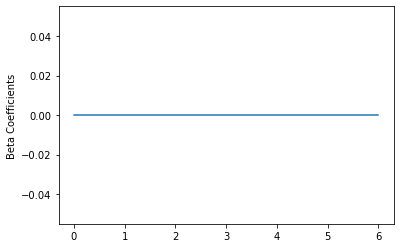

In [14]:
import matplotlib.pyplot as plt
import numpy as np

print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

#### Plot ROC curve

objectiveHistory:
0.6533754842037881
+---+---+
|FPR|TPR|
+---+---+
|0.0|0.0|
|1.0|1.0|
|1.0|1.0|
+---+---+

areaUnderROC: 0.5


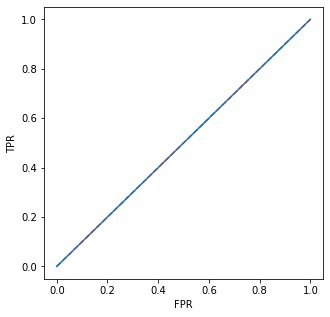

In [15]:
trainingSummary = model.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### Multilayer Perceptron Classifier Model

Multilayer perceptron classifier (MLPC) is a classifier based on the feedforward artificial neural network. MLPC consists of multiple layers of nodes. Each layer is fully connected to the next layer in the network. Nodes in the input layer represent the input data. All other nodes map inputs to outputs by a linear combination of the inputs with the node’s weights w and bias b and applying an activation function.

This can be written in matrix form for MLPC with K+1 layers as follows:

&emsp;&emsp;$y$($x$) = $f_{K}$(...$f_{2}$($w_{2}^{T}$$f_{1}$($w_{1}^{T}$x+$b_{1}$)+$b_{2}$)...+$b_{K}$)

Nodes in intermediate layers : sigmoid (logistic) function \
Nodes in the output layer : softmax function \
The number of nodes N in the output layer corresponds to the number of classes.

MLPC employs backpropagation for learning the model. We use the logistic loss function for optimization and L-BFGS as an optimization routine.

In [16]:
# from pyspark.ml.feature import StandardScaler
# from pyspark.ml import Pipeline
# from pyspark.ml.classification import MultilayerPerceptronClassifier
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# layers = [4, 5, 4, 3]
# scaler = StandardScaler(inputCol="features", outputCol="feature",withStd=True, withMean=True)
# mlpc = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
# ml_pipeline = Pipeline(stages=[scaler, mlpc])

# model = ml_pipeline.fit(training_data)

# result = model.transform(test_data)


# predictionAndLabels = result.select("prediction", "label")
# evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
# print("Test set accuracy = " + str(evaluator.evaluate(result)))